# Comparaison SGD, RMSProp, ADAM

But : présenter rapidement ces différentes méthodes et étudier leurs performances dans le cadre de l’entraînement d’un réseau de neurones. En particulier, il faudra étudier la vitesse de convergence et la sensibilité aux hyperparamètres, notamment l’impact de la taille des batchs.

Ce notebook est organisé en deux grandes parties : 

1. Une première partie avec un Multi-Layer-Perceptron avec une seule couche cachée, ou nous avons implementé "à la main" les différents optimiseurs. 
2. Une deuxième partie ou nous complexifions un peu le MLP et utilisons les optimiseurs disponibles dans PyTorch afin de produire plus facilement différentes analyses.

Dans les deux sections, nous utilisons le jeu de données synthétique **make_moons**, qui produit deux amas de points en forme de croissants entrelacés. Ce dataset est particulièrement adapté pour tester la capacité d’un modèle à capturer des frontières de décision non linéaires.

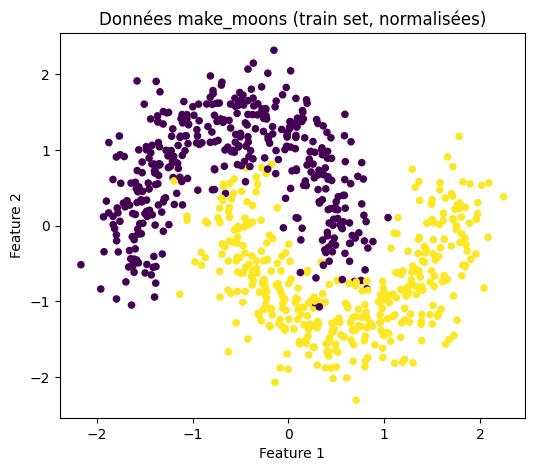

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Scatter plot des données avec une couleur par classe
plt.figure(figsize=(6, 5))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Données make_moons (train set, normalisées)")
plt.show()

# 1. MLP simple : construction from scratch et comparaison d’optimiseurs

Ci-dessous notre implémentation d'un réseau de neuronnes (MLP) simple à une seule couche cachée. Ce MLP nous permettra de tester nos implémentations des différents optimiseurs. 

In [34]:
class ReseauNeurones:
    def __init__(self, taille_entree=2, taille_cachee=16, taille_sortie=1):
        # Initialisation des poids
        self.W1 = np.random.randn(taille_entree, taille_cachee) * 0.1
        self.b1 = np.zeros(taille_cachee)
        self.W2 = np.random.randn(taille_cachee, taille_sortie) * 0.1
        self.b2 = np.zeros(taille_sortie)
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def relu(self, x):
        return np.maximum(0, x)
    
    def forward(self, X):
        # Couche cachée avec ReLU
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)
        
        # Couche de sortie avec Sigmoid
        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.sigmoid(self.z2)
        return self.a2
    
    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        
        # Gradient de la sortie
        dz2 = self.a2 - y.reshape(-1, 1)
        dW2 = (self.a1.T @ dz2) / m
        db2 = np.sum(dz2, axis=0) / m
        
        # Gradient de la couche cachée
        da1 = dz2 @ self.W2.T
        dz1 = da1 * (self.z1 > 0)
        dW1 = (X.T @ dz1) / m
        db1 = np.sum(dz1, axis=0) / m
        
        return dW1, db1, dW2, db2
    
    def calculer_loss(self, X, y):
        predictions = self.forward(X)
        return -np.mean(y * np.log(predictions + 1e-8) + (1 - y) * np.log(1 - predictions + 1e-8))  #formule de l'entropie croisée en classif binaire
    
    def calculer_accuracy(self, X, y):
        predictions = self.forward(X)
        predictions_binaires = (predictions > 0.5).astype(int).flatten()
        return np.mean(predictions_binaires == y)

Enfin, notre implémentation des optimiseurs qu'on étudie : Stochastic Gradient Descent (SGD), Root Mean Square Propagation (RMSProp), et Adaptive Moment Estimation (Adam). Ces implémentations intègrent directement une boucle d'entraînement (qu'on aurait pu séparer). 

## SGD

In [35]:
def sgd(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        # Mini-batches
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            # Forward + Backward
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            # Mise à jour SGD simple
            modele.W1 -= lr * dW1
            modele.b1 -= lr * db1
            modele.W2 -= lr * dW2
            modele.b2 -= lr * db2
        
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique


## RMSProp

In [36]:
def rmsprop(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01, rho=0.9):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    # Initialisation des accumulateurs
    vW1 = np.zeros_like(modele.W1)
    vb1 = np.zeros_like(modele.b1)
    vW2 = np.zeros_like(modele.W2)
    vb2 = np.zeros_like(modele.b2)
    epsilon = 1e-8
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            # Mise à jour RMSProp
            vW1 = rho * vW1 + (1 - rho) * dW1**2
            vb1 = rho * vb1 + (1 - rho) * db1**2
            vW2 = rho * vW2 + (1 - rho) * dW2**2
            vb2 = rho * vb2 + (1 - rho) * db2**2
            
            modele.W1 -= lr * dW1 / (np.sqrt(vW1) + epsilon)
            modele.b1 -= lr * db1 / (np.sqrt(vb1) + epsilon)
            modele.W2 -= lr * dW2 / (np.sqrt(vW2) + epsilon)
            modele.b2 -= lr * db2 / (np.sqrt(vb2) + epsilon)
        
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique



## ADAM

In [37]:
def adam(modele, X_train, y_train, X_test, y_test, epochs=50, batch_size=32, lr=0.01, beta1=0.9, beta2=0.999):
    historique = {'loss': [], 'val_loss': [], 'accuracy': []}
    
    # Initialisation
    mW1, vW1 = np.zeros_like(modele.W1), np.zeros_like(modele.W1)
    mb1, vb1 = np.zeros_like(modele.b1), np.zeros_like(modele.b1)
    mW2, vW2 = np.zeros_like(modele.W2), np.zeros_like(modele.W2)
    mb2, vb2 = np.zeros_like(modele.b2), np.zeros_like(modele.b2)
    epsilon = 1e-8
    t = 0
    
    for epoch in range(epochs):
        indices = np.random.permutation(len(X_train))
        X_shuffled = X_train[indices]
        y_shuffled = y_train[indices]
        
        for i in range(0, len(X_train), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            modele.forward(X_batch)
            dW1, db1, dW2, db2 = modele.backward(X_batch, y_batch, lr)
            
            t += 1
            
            # Mise à jour ADAM (moment + RMSProp + correction de biais)
            mW1 = beta1 * mW1 + (1 - beta1) * dW1
            mb1 = beta1 * mb1 + (1 - beta1) * db1
            mW2 = beta1 * mW2 + (1 - beta1) * dW2
            mb2 = beta1 * mb2 + (1 - beta1) * db2
            
            vW1 = beta2 * vW1 + (1 - beta2) * dW1**2
            vb1 = beta2 * vb1 + (1 - beta2) * db1**2
            vW2 = beta2 * vW2 + (1 - beta2) * dW2**2
            vb2 = beta2 * vb2 + (1 - beta2) * db2**2
            
            # Correction de biais
            mW1_corr = mW1 / (1 - beta1**t)
            mb1_corr = mb1 / (1 - beta1**t)
            mW2_corr = mW2 / (1 - beta1**t)
            mb2_corr = mb2 / (1 - beta1**t)
            
            vW1_corr = vW1 / (1 - beta2**t)
            vb1_corr = vb1 / (1 - beta2**t)
            vW2_corr = vW2 / (1 - beta2**t)
            vb2_corr = vb2 / (1 - beta2**t)
            
            modele.W1 -= lr * mW1_corr / (np.sqrt(vW1_corr) + epsilon)
            modele.b1 -= lr * mb1_corr / (np.sqrt(vb1_corr) + epsilon)
            modele.W2 -= lr * mW2_corr / (np.sqrt(vW2_corr) + epsilon)
            modele.b2 -= lr * mb2_corr / (np.sqrt(vb2_corr) + epsilon)
        
        
        historique['accuracy'].append(modele.calculer_accuracy(X_test, y_test))
    
    return historique



## Utilisation

In [38]:
# Configuration
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01

#Entraînement avec SGD
modele_sgd = ReseauNeurones()
hist_sgd = sgd(modele_sgd, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

#Entraînement avec RMSProp
modele_rmsprop = ReseauNeurones()
hist_rmsprop = rmsprop(modele_rmsprop, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

#Entraînement avec ADAM
modele_adam = ReseauNeurones()
hist_adam = adam(modele_adam, X_train, y_train, X_test, y_test, EPOCHS, BATCH_SIZE, LEARNING_RATE)

# Affichage des résultats
print(f"\nRésultats finaux (sur le split test):")
print(f"SGD     : {hist_sgd['accuracy'][-1]:.2%}")
print(f"RMSProp : {hist_rmsprop['accuracy'][-1]:.2%}")
print(f"ADAM    : {hist_adam['accuracy'][-1]:.2%}")


Résultats finaux (sur le split test):
SGD     : 86.00%
RMSProp : 87.00%
ADAM    : 98.00%


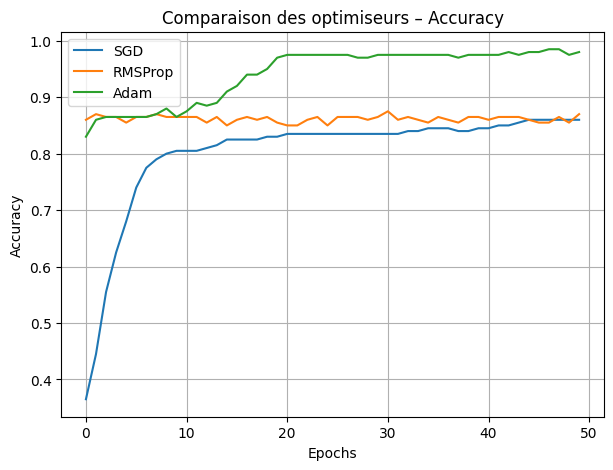

In [39]:
plt.figure(figsize=(7,5))
plt.plot(hist_sgd["accuracy"], label="SGD")
plt.plot(hist_rmsprop["accuracy"], label="RMSProp")
plt.plot(hist_adam["accuracy"], label="Adam")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Comparaison des optimiseurs – Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 2. MLP étendu : utilisation des optimiseurs PyTorch pour analyses approfondies

## Partie 1 : Comparaison avec des hyperparamètres fixés

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import time

In [41]:
# =============================================================================
# DATA LOADING AND PREPARATION
# =============================================================================
# Reproduce the same data loading as in the Streamlit dashboard

# Generate synthetic make_moons dataset
X, y = make_moons(n_samples=800, noise=0.25, random_state=0)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print(f"Dataset shapes:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")
print(f"Classes: {torch.unique(y_train_tensor)}")

Dataset shapes:
X_train: torch.Size([560, 2]), y_train: torch.Size([560])
X_test: torch.Size([240, 2]), y_test: torch.Size([240])
Classes: tensor([0, 1])


In [42]:
# =============================================================================
# NEURAL NETWORK ARCHITECTURE AND OPTIMIZERS
# =============================================================================
# This section reproduces the neural network and optimizers used in the Streamlit dashboard
# but in a static, more scientific manner with detailed comments and analysis capabilities

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 16),    # Input to first hidden layer
            nn.ReLU(),           # Non-linear activation
            nn.Linear(16, 8),    # First hidden to second hidden layer
            nn.ReLU(),           # Non-linear activation
            nn.Linear(8, 2)      # Second hidden to output layer (2 classes)
        )

    def forward(self, x):
        return self.layers(x)

def create_optimizer(model, optimizer_type, learning_rate):
    if optimizer_type == "SGD":
        return optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == "RMSprop":
        return optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_type == "Adam":
        return optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer type: {optimizer_type}")


# =============================================================================
# TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def compute_metrics(model, X, y):
    model.eval()
    with torch.no_grad():
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)

        y_pred = predicted.cpu().numpy()
        y_true = y.cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cm = confusion_matrix(y_true, y_pred)

    return acc, prec, rec, f1, cm

def compute_gradient_norms(model):
    """
    Compute L2 norm of gradients for each parameter tensor.
    Useful for analyzing gradient behavior during training.

    Returns:
    - List of gradient norms for each parameter
    """
    grad_norms = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            grad_norms.append(param.grad.norm().item())
    return grad_norms

def detect_convergence(losses, window=5, threshold=0.01):
    if len(losses) < window:
        return False, -1

    recent_losses = losses[-window:]
    loss_change = np.std(recent_losses)

    if loss_change < threshold:
        for i in range(len(losses) - window + 1):
            window_losses = losses[i:i+window]
            if np.std(window_losses) < threshold:
                return True, i + window

    return False, -1

def compute_convergence_speed(losses, target_percentile=0.95):
    if len(losses) == 0:
        return -1

    final_loss = losses[-1]
    initial_loss = losses[0]
    target_loss = initial_loss - (initial_loss - final_loss) * target_percentile

    for epoch, loss in enumerate(losses):
        if loss <= target_loss:
            return epoch + 1

    return len(losses)

def compute_loss_smoothness(losses, window=5):
    if len(losses) < window:
        return []

    smoothness = []
    for i in range(len(losses) - window + 1):
        window_losses = losses[i:i+window]
        smoothness.append(np.std(window_losses))

    return smoothness

def train_model(model, optimizer, scheduler, X_train, y_train, X_test, y_test,
                epochs=50, batch_size=32, compute_extra_metrics=True):
    """
    Train a neural network and collect comprehensive training metrics.

    This function reproduces the training loop from the dashboard but in a more
    modular way, suitable for scientific analysis and comparison.

    Parameters:
    - model: PyTorch model to train
    - optimizer: PyTorch optimizer
    - scheduler: Learning rate scheduler (optional)
    - X_train, y_train: Training data tensors
    - X_test, y_test: Test data tensors
    - epochs: Number of training epochs
    - batch_size: Mini-batch size
    - compute_extra_metrics: Whether to compute gradient norms and convergence analysis

    Returns:
    - Dictionary containing all training metrics and analysis results
    """

    # Initialize metric tracking
    train_losses = []
    val_losses = []
    train_accs, test_accs = [], []
    train_precs, test_precs = [], []
    train_recs, test_recs = [], []
    train_f1s, test_f1s = [], []
    learning_rates = []
    gradient_norms_history = []

    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        total_loss = 0.0
        epoch_grad_norms = []  # Collect gradient norms for this epoch

        # Mini-batch training
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()

            # Collect gradient norms for this batch
            if compute_extra_metrics:
                grad_norms = compute_gradient_norms(model)
                if grad_norms:
                    epoch_grad_norms.append(np.mean(grad_norms))

            optimizer.step()
            total_loss += loss.item()

        # Store average gradient norm for this epoch
        if epoch_grad_norms:
            gradient_norms_history.append(np.mean(epoch_grad_norms))
        else:
            gradient_norms_history.append(0)

        # Update learning rate and track it
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        if scheduler:
            scheduler.step()

        # Compute average training loss for this epoch
        avg_train_loss = total_loss / (X_train.size(0) / batch_size)
        train_losses.append(avg_train_loss)

        # Compute validation loss
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test)
            val_loss = criterion(val_outputs, y_test)
            val_losses.append(val_loss.item())

        # Compute comprehensive metrics
        train_acc, train_prec, train_rec, train_f1, _ = compute_metrics(model, X_train, y_train)
        test_acc, test_prec, test_rec, test_f1, cm = compute_metrics(model, X_test, y_test)

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        train_precs.append(train_prec)
        test_precs.append(test_prec)
        train_recs.append(train_rec)
        test_recs.append(test_rec)
        train_f1s.append(train_f1)
        test_f1s.append(test_f1)

    training_time = time.time() - start_time

    # Convergence analysis
    converged, convergence_epoch = detect_convergence(val_losses)
    convergence_speed_95 = compute_convergence_speed(val_losses, 0.95)
    convergence_speed_99 = compute_convergence_speed(val_losses, 0.99)
    loss_smoothness = compute_loss_smoothness(val_losses)

    # Return comprehensive results
    results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
        'train_precs': train_precs,
        'test_precs': test_precs,
        'train_recs': train_recs,
        'test_recs': test_recs,
        'train_f1s': train_f1s,
        'test_f1s': test_f1s,
        'learning_rates': learning_rates,
        'gradient_norms': gradient_norms_history,
        'confusion_matrix': cm,
        'training_time': training_time,
        'final_test_acc': test_accs[-1],
        'final_train_loss': train_losses[-1],
        'final_val_loss': val_losses[-1],
        'converged': converged,
        'convergence_epoch': convergence_epoch,
        'convergence_speed_95': convergence_speed_95,
        'convergence_speed_99': convergence_speed_99,
        'loss_smoothness': loss_smoothness
    }

    return results

# =============================================================================
# UTILITY FUNCTIONS FOR ANALYSIS
# =============================================================================

def compare_optimizers(X_train, y_train, X_test, y_test,
                      optimizers=['SGD', 'RMSprop', 'Adam'],
                      learning_rate=0.01, epochs=50, batch_size=64):

    results = {}
    colors = {'SGD': '#FF6B6B', 'RMSprop': '#4ECDC4', 'Adam': '#45B7D1'}

    for opt_name in optimizers:

        # Create fresh model and optimizer for each experiment
        model = MLP()
        optimizer = create_optimizer(model, opt_name, learning_rate)

        # Train and collect results
        result = train_model(model, optimizer, None, X_train, y_train, X_test, y_test,
                           epochs, batch_size)

        result['color'] = colors.get(opt_name, '#333333')
        results[opt_name] = result

    return results

In [43]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_losses(results):
    """
    Plot training and validation losses for all optimizers.
    """
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['train_losses']) + 1)
        plt.plot(epochs, result['train_losses'], label=f'{opt_name} Train', color=result['color'], linestyle='--')
        plt.plot(epochs, result['val_losses'], label=f'{opt_name} Val', color=result['color'], linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_accuracy(results):
    """
    Plot training and test accuracy for all optimizers.
    """
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['train_accs']) + 1)
        plt.plot(epochs, result['train_accs'], label=f'{opt_name} Train', color=result['color'], linestyle='--')
        plt.plot(epochs, result['test_accs'], label=f'{opt_name} Test', color=result['color'], linestyle='-')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_gradient_norms(results):
    """
    Plot gradient norms over epochs for all optimizers.
    """
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['gradient_norms']) + 1)
        plt.plot(epochs, result['gradient_norms'], label=opt_name, color=result['color'])

    plt.xlabel('Epochs')
    plt.ylabel('Gradient Norm (L2)')
    plt.title('Gradient Norms During Training')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')  # Log scale for better visualization
    plt.show()

def plot_training_stability(results):
    """
    Plot training stability metrics (loss smoothness) for all optimizers.
    """
    plt.figure(figsize=(12, 8))

    for opt_name, result in results.items():
        epochs = range(1, len(result['loss_smoothness']) + 1)
        plt.plot(epochs, result['loss_smoothness'], label=opt_name, color=result['color'])

    plt.xlabel('Epochs')
    plt.ylabel('Loss Smoothness (Std Dev)')
    plt.title('Training Stability (Loss Smoothness)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


FINAL RESULTS SUMMARY
SGD     : Test Acc = 87.50%, Train Loss = 0.3552, Val Loss = 0.3279, Time = 1.52s
         Converged at epoch 29
RMSprop : Test Acc = 92.92%, Train Loss = 0.1161, Val Loss = 0.1981, Time = 1.28s
         Converged at epoch 8
Adam    : Test Acc = 93.33%, Train Loss = 0.1174, Val Loss = 0.1760, Time = 1.55s
         Converged at epoch 15


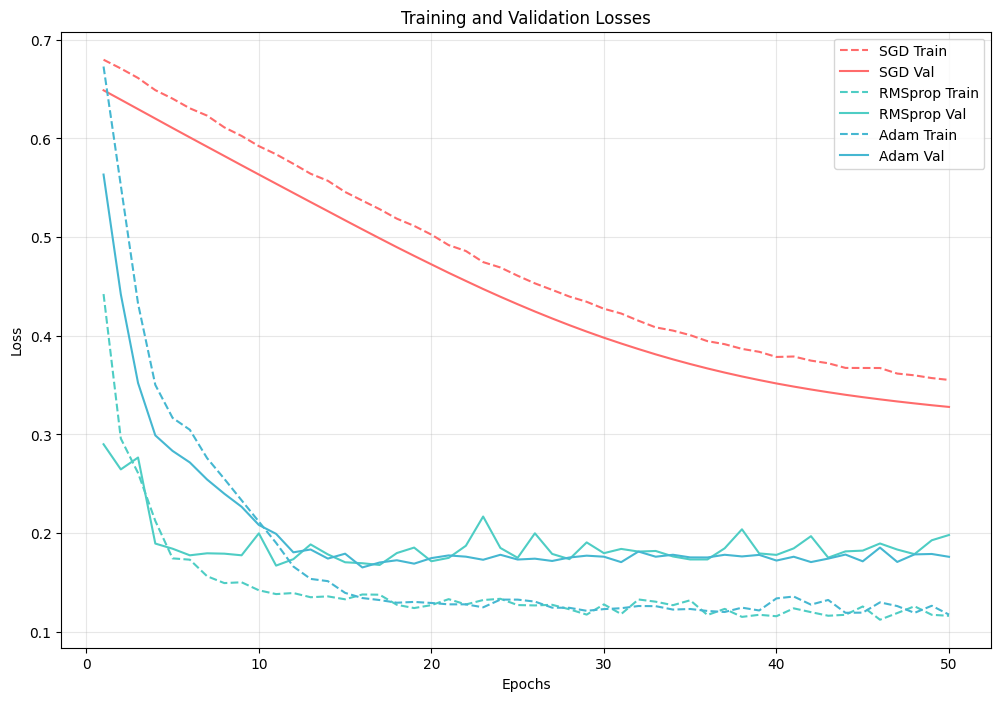

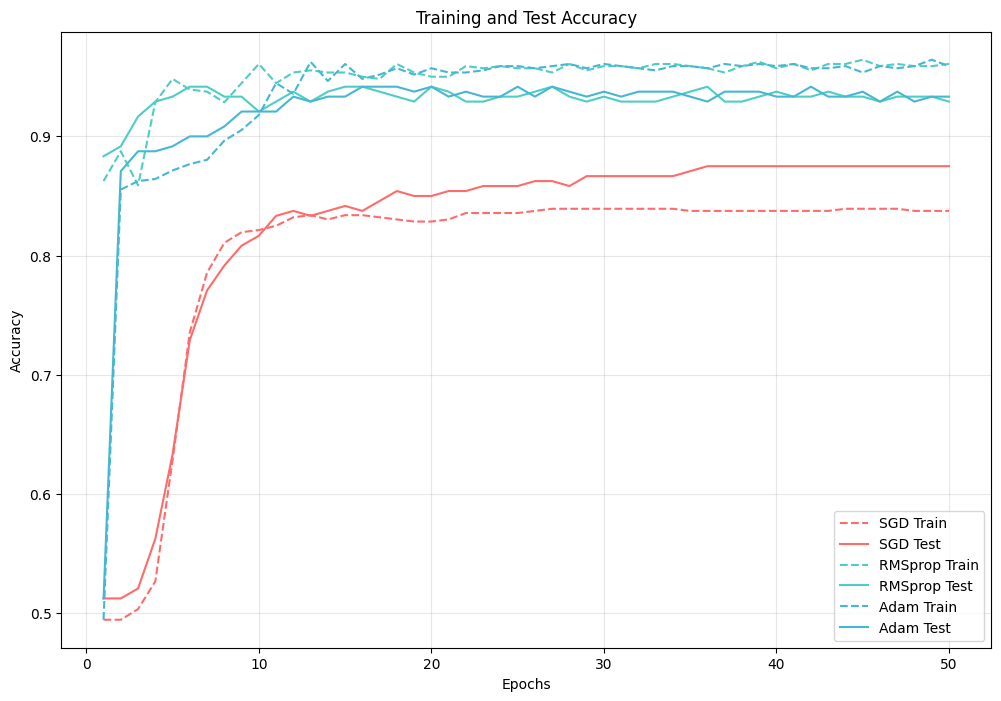

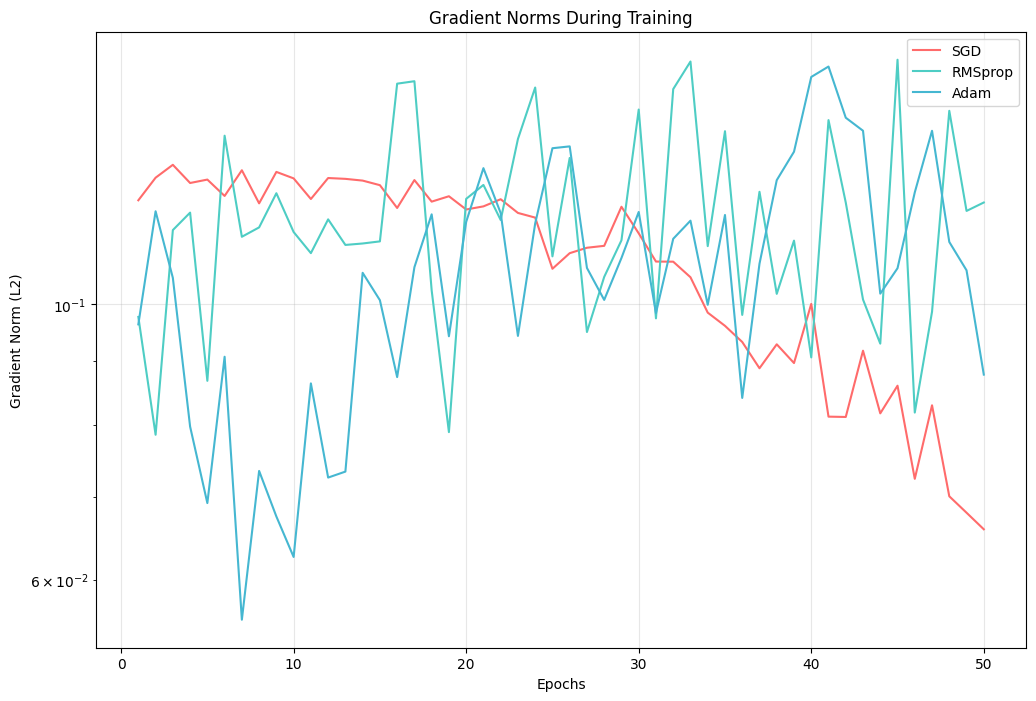

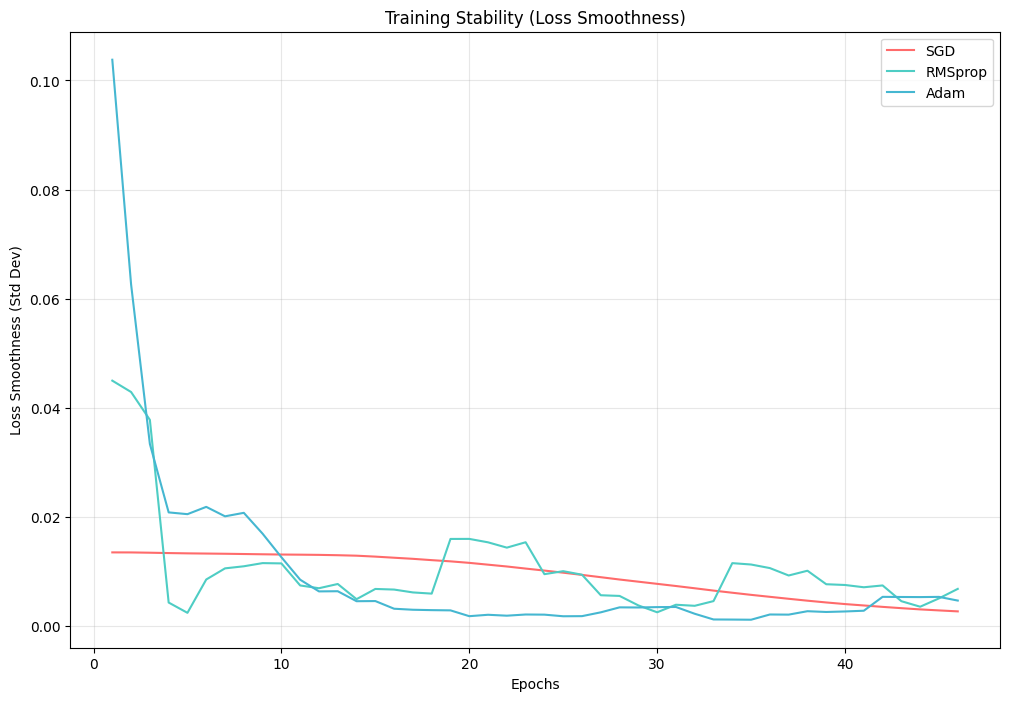

In [44]:
# =============================================================================
# RUN OPTIMIZER COMPARISON AND VISUALIZE RESULTS
# =============================================================================

# Run the comparison
results = compare_optimizers(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
                           optimizers=['SGD', 'RMSprop', 'Adam'],
                           learning_rate=0.01, epochs=50, batch_size=64)

# Display final results summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
for opt_name, result in results.items():
    print(f"{opt_name:8}: Test Acc = {result['final_test_acc']:.2%}, "
          f"Train Loss = {result['final_train_loss']:.4f}, "
          f"Val Loss = {result['final_val_loss']:.4f}, "
          f"Time = {result['training_time']:.2f}s")
    if result['converged']:
        print(f"         Converged at epoch {result['convergence_epoch']}")
    else:
        print("         Did not converge")

# Plot the results
plot_losses(results)
plot_accuracy(results)
plot_gradient_norms(results)
plot_training_stability(results)

## Interprétations de ces résultats : 

- Interprétation 1
- Interprétation 1
- Interprétation 1
- Interprétation 1
- Interprétation 1


## Partie 2 : Sensibilité aux hyerparamètres

Running hyperparameter sensitivity analysis...
Learning rates: [0.001, 0.005, 0.01, 0.05, 0.1]
Batch sizes: [16, 32, 64, 128]
Optimizers: ['SGD', 'RMSprop', 'Adam']
Epochs per configuration: 30

--- Testing SGD ---
Run 1/60: SGD - LR=0.0010, BS=16
Run 2/60: SGD - LR=0.0050, BS=16
Run 2/60: SGD - LR=0.0050, BS=16
Run 3/60: SGD - LR=0.0100, BS=16
Run 3/60: SGD - LR=0.0100, BS=16
Run 4/60: SGD - LR=0.0500, BS=16
Run 4/60: SGD - LR=0.0500, BS=16
Run 5/60: SGD - LR=0.1000, BS=16
Run 5/60: SGD - LR=0.1000, BS=16
Run 6/60: SGD - LR=0.0010, BS=32
Run 6/60: SGD - LR=0.0010, BS=32
Run 7/60: SGD - LR=0.0050, BS=32
Run 7/60: SGD - LR=0.0050, BS=32
Run 8/60: SGD - LR=0.0100, BS=32
Run 8/60: SGD - LR=0.0100, BS=32
Run 9/60: SGD - LR=0.0500, BS=32
Run 9/60: SGD - LR=0.0500, BS=32
Run 10/60: SGD - LR=0.1000, BS=32
Run 10/60: SGD - LR=0.1000, BS=32
Run 11/60: SGD - LR=0.0010, BS=64
Run 11/60: SGD - LR=0.0010, BS=64
Run 12/60: SGD - LR=0.0050, BS=64
Run 12/60: SGD - LR=0.0050, BS=64
Run 13/60: SGD - LR=

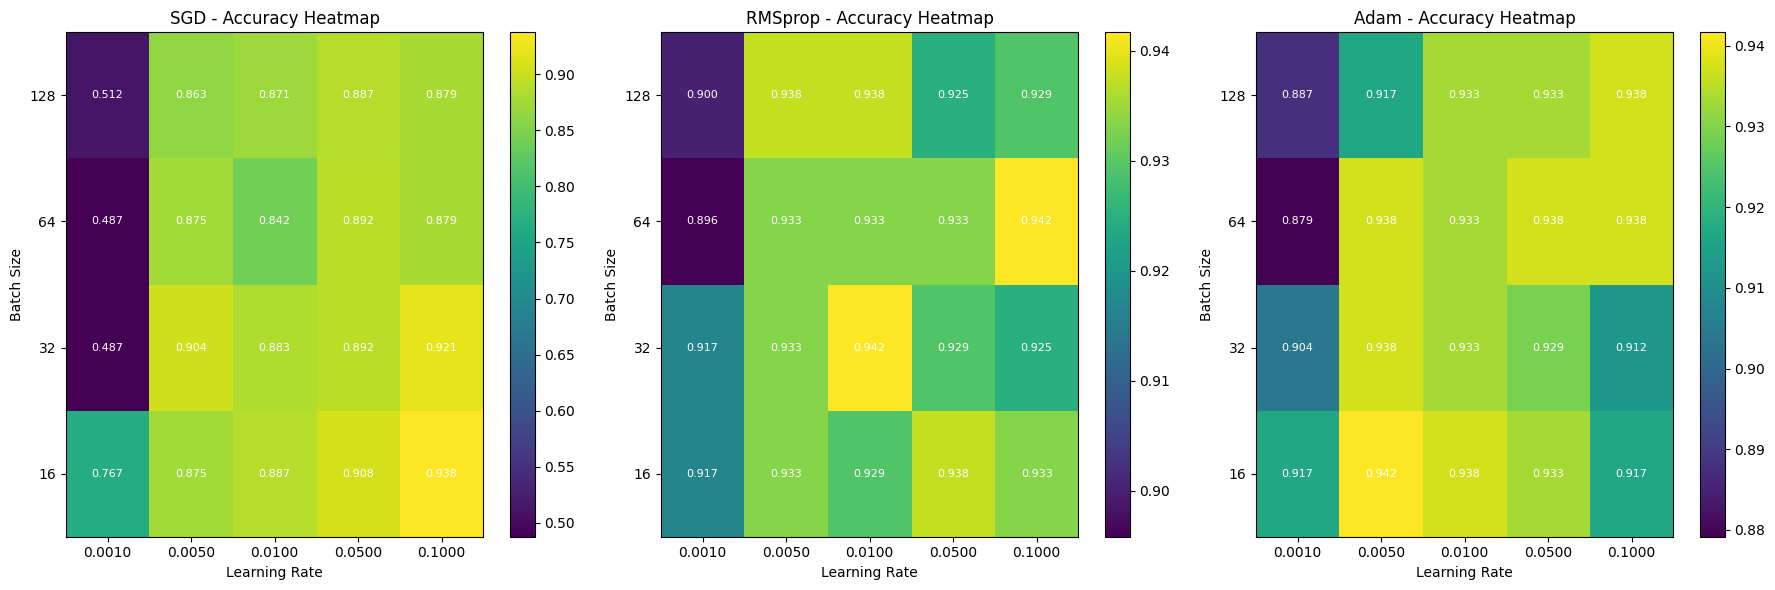

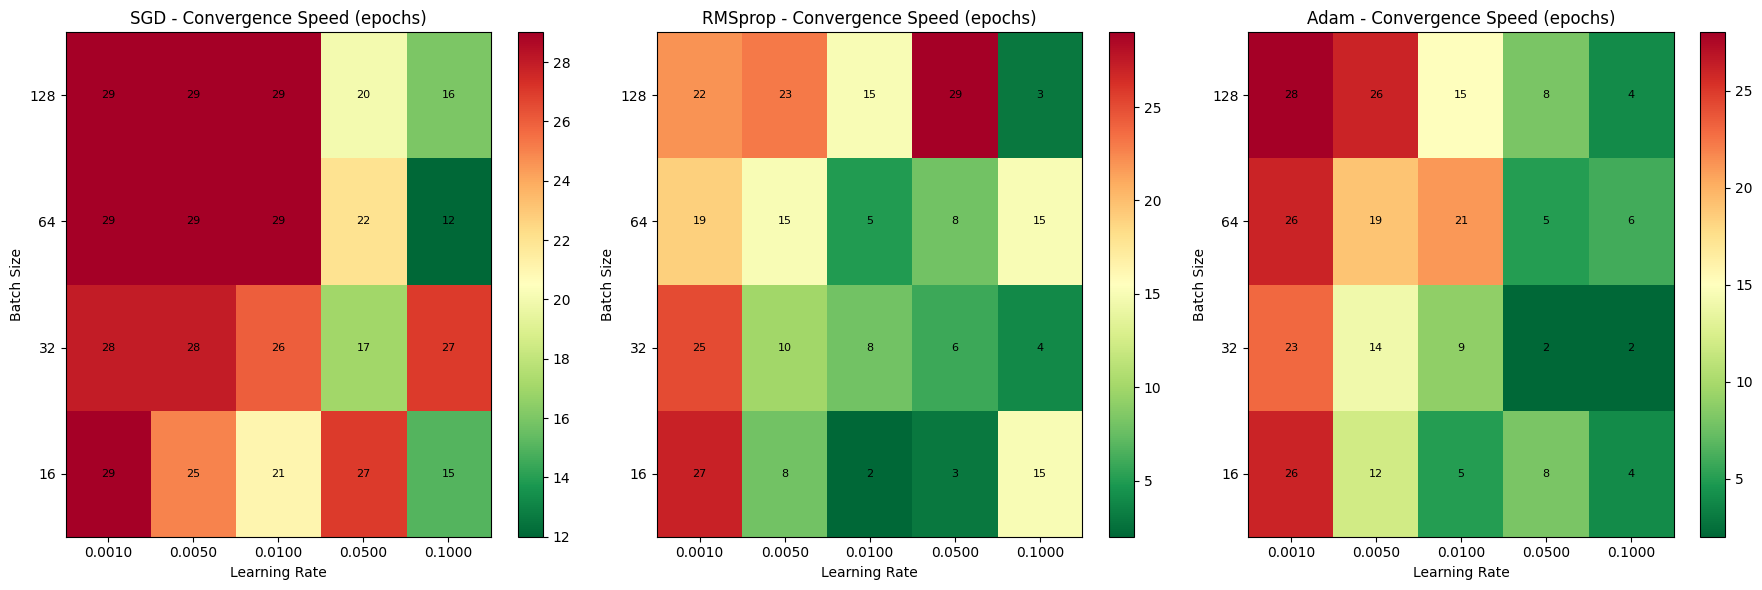

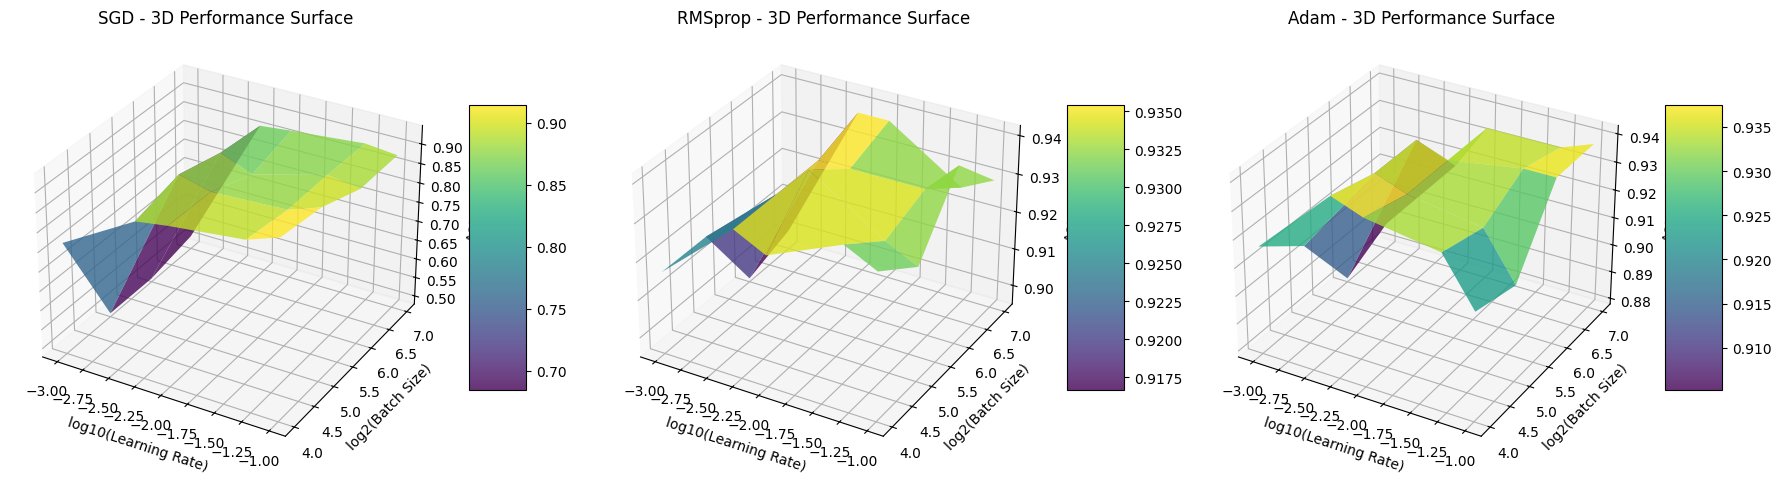

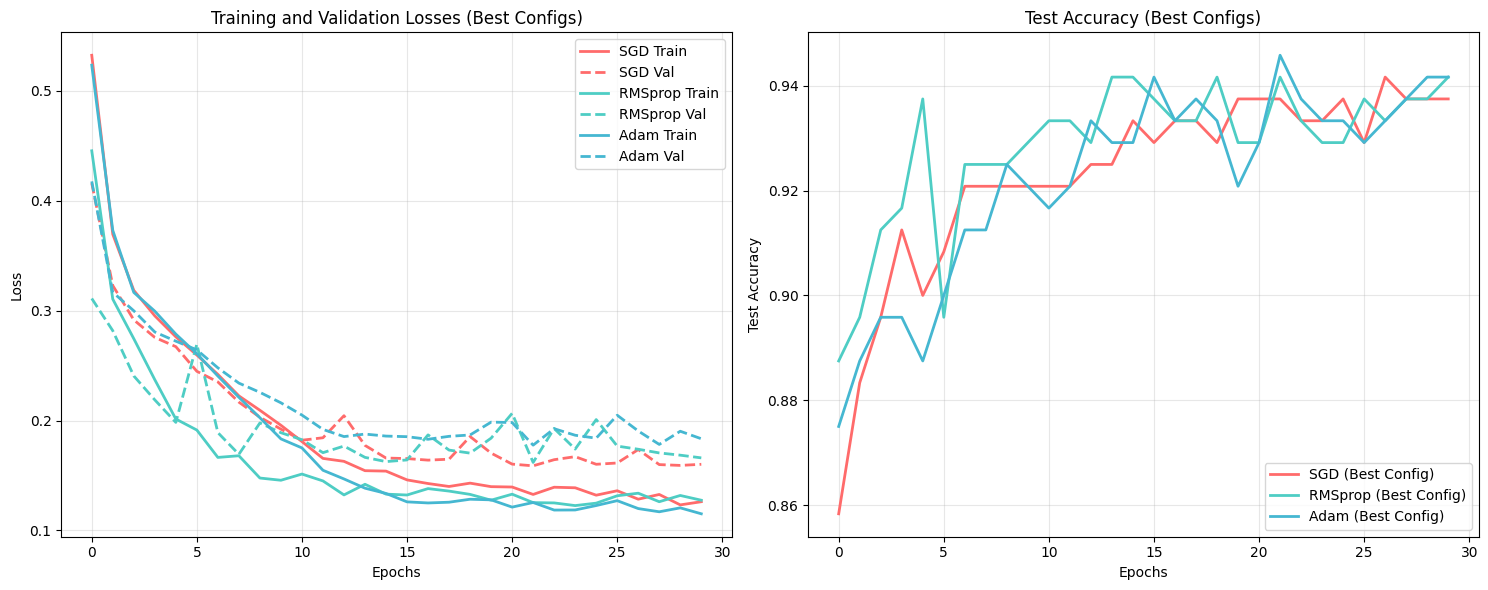

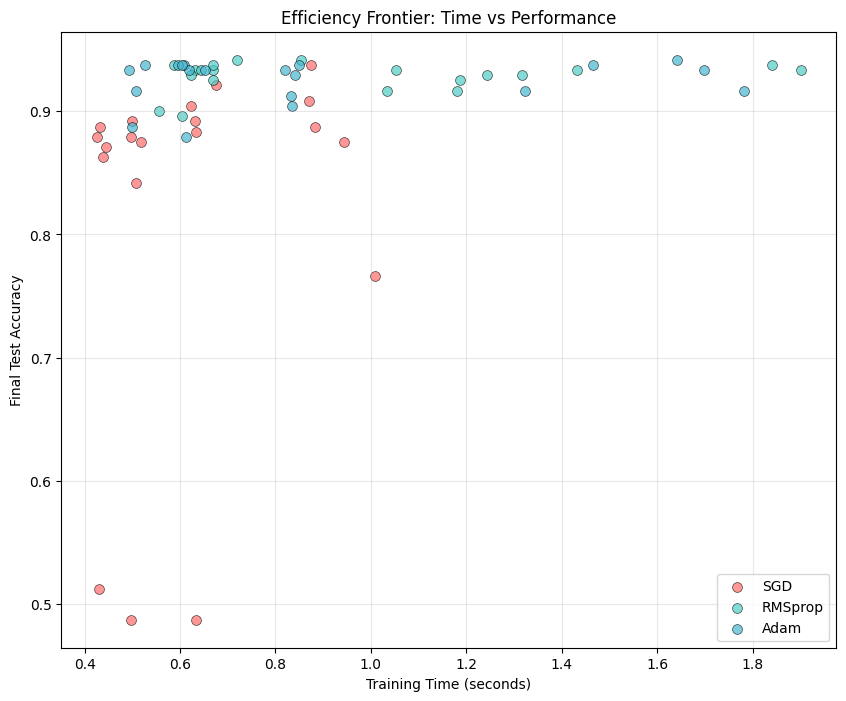

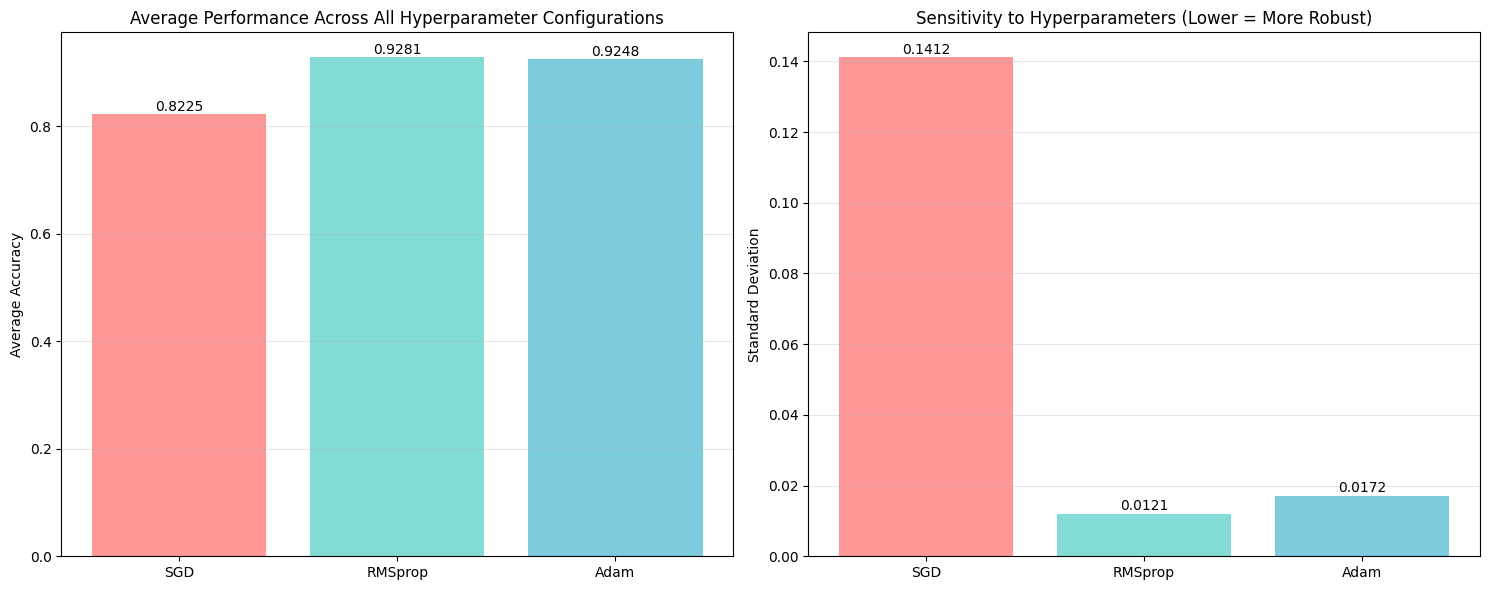

Hyperparameter sensitivity analysis completed!


In [45]:
# =============================================================================
# HYPERPARAMETER SENSITIVITY ANALYSIS
# =============================================================================

def run_hyperparameter_sensitivity(X_train, y_train, X_test, y_test,
                                  learning_rates=None, batch_sizes=None,
                                  optimizers=['SGD', 'RMSprop', 'Adam'],
                                  epochs=30):
    """
    Perform grid search over learning rates and batch sizes for all optimizers.
    
    Returns comprehensive results for analysis and visualization.
    """
    
    if learning_rates is None:
        learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
    if batch_sizes is None:
        batch_sizes = [16, 32, 64, 128]
    
    colors = {'SGD': '#FF6B6B', 'RMSprop': '#4ECDC4', 'Adam': '#45B7D1'}
    
    results_per_optimizer = {}
    
    print(f"Running hyperparameter sensitivity analysis...")
    print(f"Learning rates: {learning_rates}")
    print(f"Batch sizes: {batch_sizes}")
    print(f"Optimizers: {optimizers}")
    print(f"Epochs per configuration: {epochs}")
    
    total_runs = len(learning_rates) * len(batch_sizes) * len(optimizers)
    run_count = 0
    
    for opt_name in optimizers:
        print(f"\n--- Testing {opt_name} ---")
        
        # Initialize result grids
        accuracy_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        convergence_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        time_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        loss_grid = np.zeros((len(batch_sizes), len(learning_rates)))
        
        detailed_results = {}
        
        for i, bs in enumerate(batch_sizes):
            for j, lr in enumerate(learning_rates):
                run_count += 1
                print(f"Run {run_count}/{total_runs}: {opt_name} - LR={lr:.4f}, BS={bs}")
                
                # Create fresh model and optimizer
                model = MLP()
                optimizer = create_optimizer(model, opt_name, lr)
                
                # Train and collect results
                start_time = time.time()
                result = train_model(model, optimizer, None, X_train, y_train, X_test, y_test,
                                   epochs=epochs, batch_size=bs, compute_extra_metrics=False)
                training_time = time.time() - start_time
                
                # Store results
                accuracy_grid[i, j] = result['final_test_acc']
                convergence_grid[i, j] = result['convergence_speed_95']
                time_grid[i, j] = training_time
                loss_grid[i, j] = result['final_val_loss']
                
                detailed_results[f"LR={lr:.4f}_BS={bs}"] = result
        
        # Store results for this optimizer
        results_per_optimizer[opt_name] = {
            'accuracy_grid': accuracy_grid,
            'convergence_grid': convergence_grid,
            'time_grid': time_grid,
            'loss_grid': loss_grid,
            'detailed_results': detailed_results,
            'color': colors.get(opt_name, '#333333'),
            'learning_rates': learning_rates,
            'batch_sizes': batch_sizes
        }
    
    print("\nHyperparameter sensitivity analysis completed!")
    return results_per_optimizer

# =============================================================================
# VISUALIZATION FUNCTIONS FOR HYPERPARAMETER SENSITIVITY
# =============================================================================

def plot_sensitivity_heatmaps(results_per_optimizer):
    """
    Plot heatmaps showing accuracy for each optimizer across learning rates and batch sizes.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (opt_name, data) in enumerate(results_per_optimizer.items()):
        ax = axes[idx]
        
        accuracy_grid = data['accuracy_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        # Create heatmap
        im = ax.imshow(accuracy_grid, cmap='viridis', aspect='auto', origin='lower')
        
        # Set ticks and labels
        ax.set_xticks(range(len(learning_rates)))
        ax.set_yticks(range(len(batch_sizes)))
        ax.set_xticklabels([f'{lr:.4f}' for lr in learning_rates])
        ax.set_yticklabels([f'{bs}' for bs in batch_sizes])
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_title(f'{opt_name} - Accuracy Heatmap')
        
        # Add text annotations
        for i in range(len(batch_sizes)):
            for j in range(len(learning_rates)):
                text = ax.text(j, i, f'{accuracy_grid[i, j]:.3f}',
                             ha="center", va="center", color="w", fontsize=8)
        
        # Colorbar
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def plot_convergence_heatmaps(results_per_optimizer):
    """
    Plot heatmaps showing convergence speed (epochs to 95% of final loss) for each optimizer.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, (opt_name, data) in enumerate(results_per_optimizer.items()):
        ax = axes[idx]
        
        convergence_grid = data['convergence_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        # Create heatmap (lower values are better, so use reverse colormap)
        im = ax.imshow(convergence_grid, cmap='RdYlGn_r', aspect='auto', origin='lower')
        
        # Set ticks and labels
        ax.set_xticks(range(len(learning_rates)))
        ax.set_yticks(range(len(batch_sizes)))
        ax.set_xticklabels([f'{lr:.4f}' for lr in learning_rates])
        ax.set_yticklabels([f'{bs}' for bs in batch_sizes])
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_title(f'{opt_name} - Convergence Speed (epochs)')
        
        # Add text annotations
        for i in range(len(batch_sizes)):
            for j in range(len(learning_rates)):
                text = ax.text(j, i, f'{convergence_grid[i, j]:.0f}',
                             ha="center", va="center", color="k", fontsize=8)
        
        # Colorbar
        plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

def plot_3d_surfaces(results_per_optimizer):
    """
    Plot 3D surfaces showing accuracy as a function of learning rate and batch size.
    """
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(18, 6))
    
    for idx, (opt_name, data) in enumerate(results_per_optimizer.items()):
        ax = fig.add_subplot(1, 3, idx+1, projection='3d')
        
        accuracy_grid = data['accuracy_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        # Create meshgrid
        LR, BS = np.meshgrid(learning_rates, batch_sizes)
        
        # Plot surface
        surf = ax.plot_surface(np.log10(LR), np.log2(BS), accuracy_grid, 
                             cmap='viridis', edgecolor='none', alpha=0.8)
        
        ax.set_xlabel('log10(Learning Rate)')
        ax.set_ylabel('log2(Batch Size)')
        ax.set_zlabel('Accuracy')
        ax.set_title(f'{opt_name} - 3D Performance Surface')
        
        # Colorbar
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    
    plt.tight_layout()
    plt.show()

def plot_best_configurations_comparison(results_per_optimizer):
    """
    Compare the best configuration for each optimizer.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    for opt_name, data in results_per_optimizer.items():
        accuracy_grid = data['accuracy_grid']
        detailed_results = data['detailed_results']
        color = data['color']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        # Find best configuration
        best_idx = np.unravel_index(np.argmax(accuracy_grid), accuracy_grid.shape)
        best_lr = learning_rates[best_idx[1]]
        best_bs = batch_sizes[best_idx[0]]
        key = f"LR={best_lr:.4f}_BS={best_bs}"
        best_result = detailed_results[key]
        
        # Plot losses
        ax1.plot(best_result['train_losses'], label=f'{opt_name} Train', 
                color=color, linewidth=2)
        ax1.plot(best_result['val_losses'], label=f'{opt_name} Val', 
                color=color, linewidth=2, linestyle='--')
        
        # Plot accuracy
        ax2.plot(best_result['test_accs'], label=f'{opt_name} (Best Config)', 
                color=color, linewidth=2)
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Losses (Best Configs)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Test Accuracy (Best Configs)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_efficiency_frontier(results_per_optimizer):
    """
    Plot efficiency frontier: training time vs final accuracy for all configurations.
    """
    plt.figure(figsize=(10, 8))
    
    for opt_name, data in results_per_optimizer.items():
        accuracy_grid = data['accuracy_grid']
        time_grid = data['time_grid']
        color = data['color']
        
        # Flatten all configurations
        times = time_grid.flatten()
        accuracies = accuracy_grid.flatten()
        
        plt.scatter(times, accuracies, c=color, alpha=0.7, s=50, 
                   label=opt_name, edgecolors='black', linewidth=0.5)
    
    plt.xlabel('Training Time (seconds)')
    plt.ylabel('Final Test Accuracy')
    plt.title('Efficiency Frontier: Time vs Performance')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_sensitivity_summary(results_per_optimizer):
    """
    Plot summary statistics: average performance and sensitivity (variance).
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    optimizers = list(results_per_optimizer.keys())
    colors = [data['color'] for data in results_per_optimizer.values()]
    
    # Average performance
    avg_accuracies = [np.mean(data['accuracy_grid'].flatten()) for data in results_per_optimizer.values()]
    ax1.bar(optimizers, avg_accuracies, color=colors, alpha=0.7)
    ax1.set_ylabel('Average Accuracy')
    ax1.set_title('Average Performance Across All Hyperparameter Configurations')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(avg_accuracies):
        ax1.text(i, v + 0.001, f'{v:.4f}', ha='center', va='bottom')
    
    # Sensitivity (standard deviation)
    std_accuracies = [np.std(data['accuracy_grid'].flatten()) for data in results_per_optimizer.values()]
    ax2.bar(optimizers, std_accuracies, color=colors, alpha=0.7)
    ax2.set_ylabel('Standard Deviation')
    ax2.set_title('Sensitivity to Hyperparameters (Lower = More Robust)')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(std_accuracies):
        ax2.text(i, v + 0.0001, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_best_configurations(results_per_optimizer):
    """
    Print a table of best configurations for each optimizer.
    """
    print("\n" + "="*80)
    print("BEST HYPERPARAMETER CONFIGURATIONS")
    print("="*80)
    print(f"{'Optimizer':<10} {'Best LR':<10} {'Best BS':<10} {'Best Acc':<10} {'Conv Speed':<12} {'Avg Time':<10}")
    print("-" * 80)
    
    for opt_name, data in results_per_optimizer.items():
        accuracy_grid = data['accuracy_grid']
        convergence_grid = data['convergence_grid']
        time_grid = data['time_grid']
        learning_rates = data['learning_rates']
        batch_sizes = data['batch_sizes']
        
        # Find best accuracy configuration
        best_acc_idx = np.unravel_index(np.argmax(accuracy_grid), accuracy_grid.shape)
        best_acc_lr = learning_rates[best_acc_idx[1]]
        best_acc_bs = batch_sizes[best_acc_idx[0]]
        best_acc = accuracy_grid[best_acc_idx]
        
        # Find fastest convergence configuration
        valid_convergence = convergence_grid[convergence_grid > 0]  # Remove invalid values
        if len(valid_convergence) > 0:
            min_conv_idx = np.unravel_index(np.argmin(convergence_grid), convergence_grid.shape)
            conv_lr = learning_rates[min_conv_idx[1]]
            conv_bs = batch_sizes[min_conv_idx[0]]
            conv_speed = convergence_grid[min_conv_idx]
        else:
            conv_lr, conv_bs, conv_speed = "N/A", "N/A", "N/A"
        
        # Average time
        avg_time = np.mean(time_grid)
        
        print(f"{opt_name:<10} {best_acc_lr:<10.4f} {best_acc_bs:<10} {best_acc:<10.4f} {conv_speed:<12.1f} {avg_time:<10.2f}")

# =============================================================================
# RUN HYPERPARAMETER SENSITIVITY ANALYSIS
# =============================================================================

# Define hyperparameter ranges for sensitivity analysis
learning_rates_sens = [0.001, 0.005, 0.01, 0.05, 0.1]
batch_sizes_sens = [16, 32, 64, 128]
epochs_sens = 30  # Shorter for sensitivity analysis

# Run the analysis
sensitivity_results = run_hyperparameter_sensitivity(
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    learning_rates=learning_rates_sens,
    batch_sizes=batch_sizes_sens,
    optimizers=['SGD', 'RMSprop', 'Adam'],
    epochs=epochs_sens
)

# Print best configurations
print_best_configurations(sensitivity_results)

# Create visualizations
print("\nGenerating sensitivity analysis plots...")

plot_sensitivity_heatmaps(sensitivity_results)
plot_convergence_heatmaps(sensitivity_results)
plot_3d_surfaces(sensitivity_results)
plot_best_configurations_comparison(sensitivity_results)
plot_efficiency_frontier(sensitivity_results)
plot_sensitivity_summary(sensitivity_results)

print("Hyperparameter sensitivity analysis completed!")

## Interprétations :

- Interp 1
- Interp 1
- Interp 1
- Interp 1
- Interp 1

## Partie 3 : Analyse de la robustesse

Running robustness analysis with 10 runs per optimizer...
Optimizers: ['SGD', 'RMSprop', 'Adam']
Hyperparameters: LR=0.01, Epochs=50, Batch Size=64

--- Testing SGD (10 runs) ---
Run 1/30: SGD - Run 1/10
Run 2/30: SGD - Run 2/10
Run 2/30: SGD - Run 2/10
Run 3/30: SGD - Run 3/10
Run 3/30: SGD - Run 3/10
Run 4/30: SGD - Run 4/10
Run 4/30: SGD - Run 4/10
Run 5/30: SGD - Run 5/10
Run 5/30: SGD - Run 5/10
Run 6/30: SGD - Run 6/10
Run 6/30: SGD - Run 6/10
Run 7/30: SGD - Run 7/10
Run 7/30: SGD - Run 7/10
Run 8/30: SGD - Run 8/10
Run 8/30: SGD - Run 8/10
Run 9/30: SGD - Run 9/10
Run 9/30: SGD - Run 9/10
Run 10/30: SGD - Run 10/10
Run 10/30: SGD - Run 10/10

--- Testing RMSprop (10 runs) ---
Run 11/30: RMSprop - Run 1/10

--- Testing RMSprop (10 runs) ---
Run 11/30: RMSprop - Run 1/10
Run 12/30: RMSprop - Run 2/10
Run 12/30: RMSprop - Run 2/10
Run 13/30: RMSprop - Run 3/10
Run 13/30: RMSprop - Run 3/10
Run 14/30: RMSprop - Run 4/10
Run 14/30: RMSprop - Run 4/10
Run 15/30: RMSprop - Run 5/10
Ru

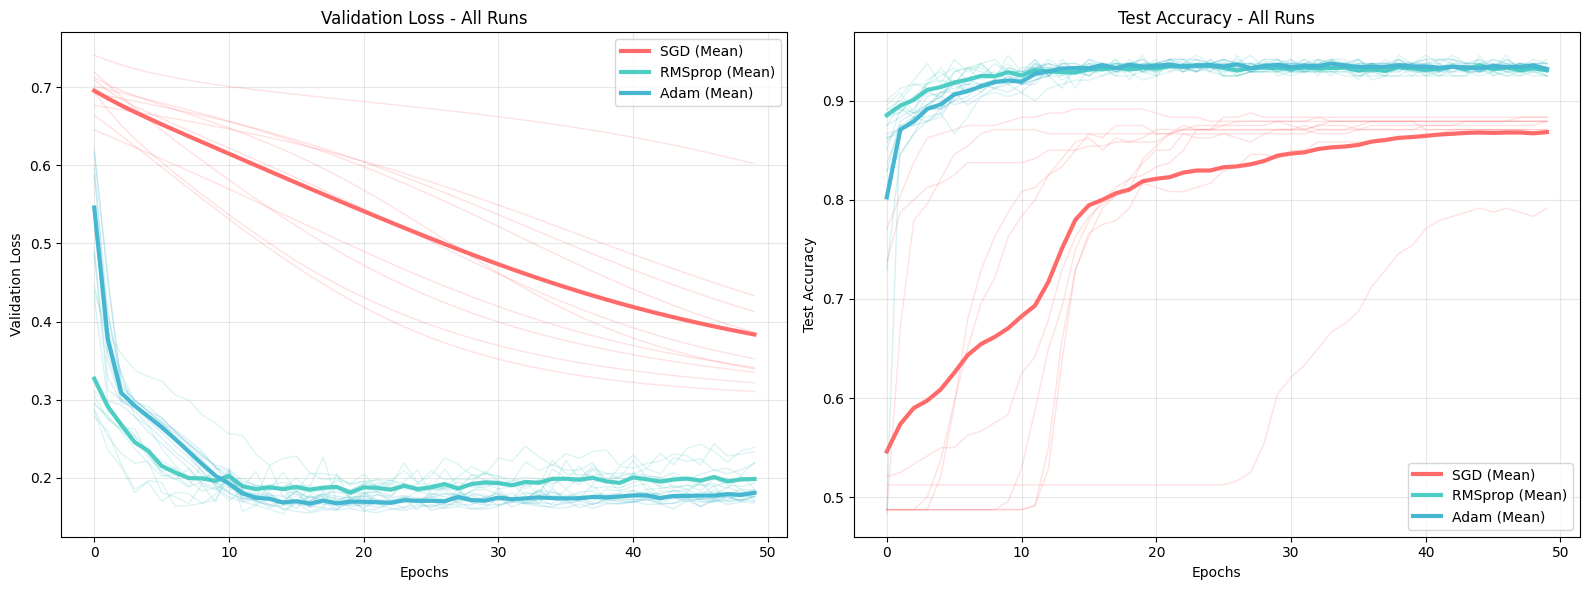

/tmp/ipykernel_14146/1560284407.py:129: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(accuracy_data, labels=optimizers, patch_artist=True)
/tmp/ipykernel_14146/1560284407.py:145: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot(val_loss_data, labels=optimizers, patch_artist=True)


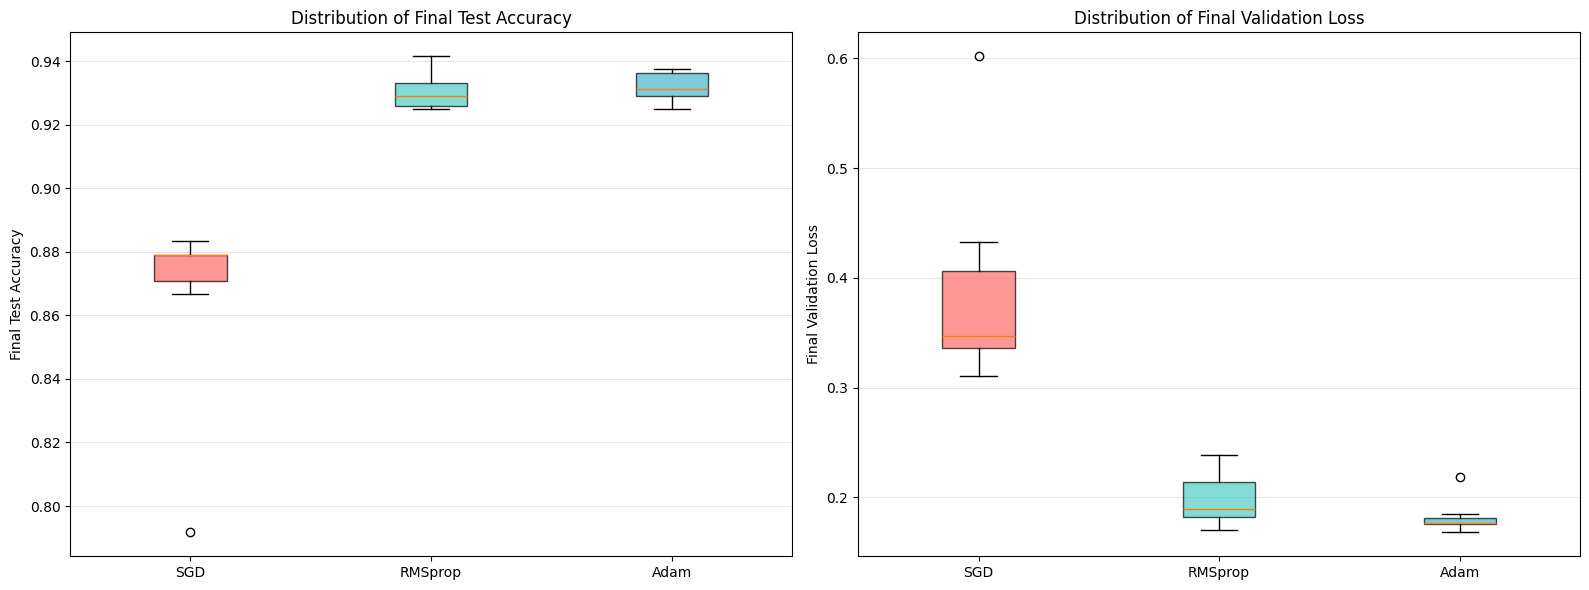

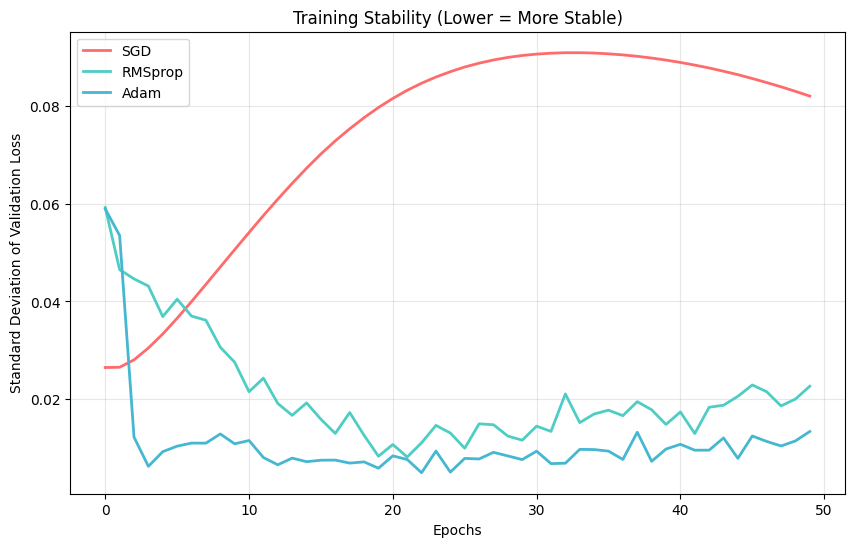

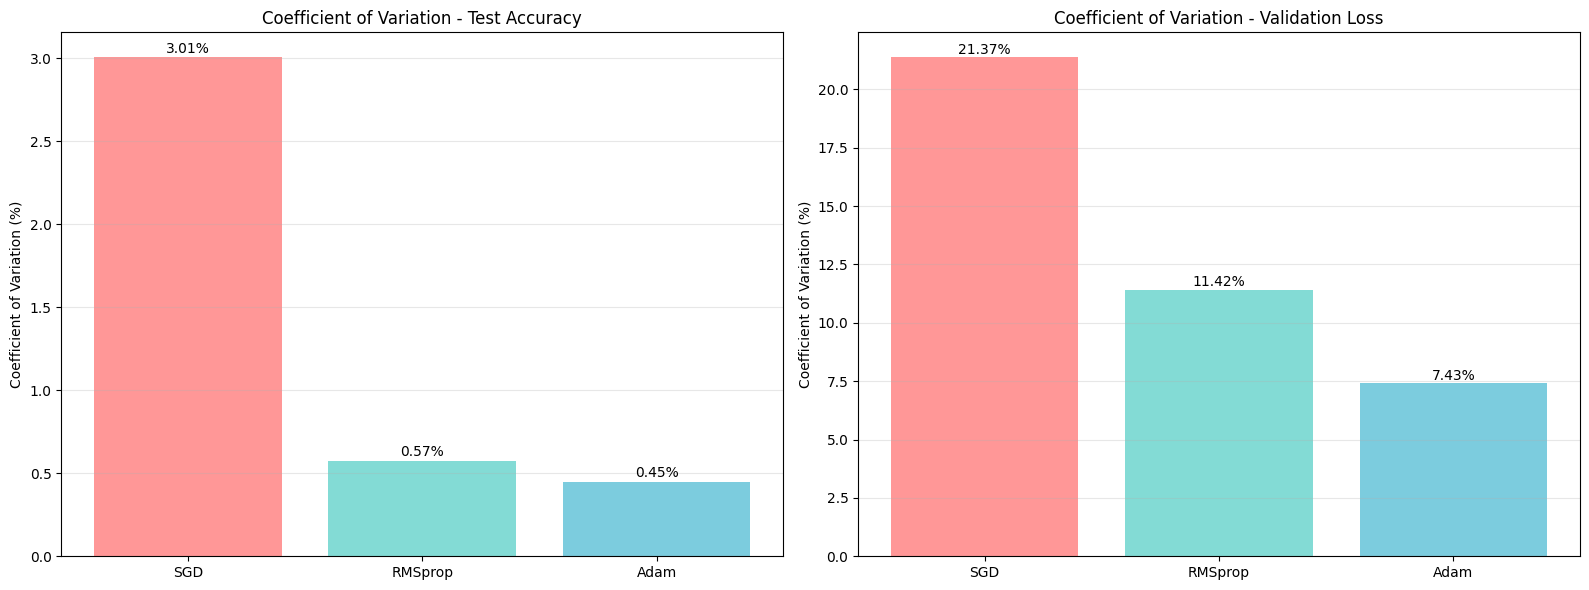

Robustness analysis completed!


In [47]:
# =============================================================================
# ROBUSTNESS ANALYSIS
# =============================================================================

def run_robustness_analysis(X_train, y_train, X_test, y_test,
                           optimizers=['SGD', 'RMSprop', 'Adam'],
                           learning_rate=0.01, epochs=50, batch_size=64,
                           n_runs=5):
    """
    Run multiple training runs for each optimizer to analyze robustness and stability.
    
    Returns results for all runs per optimizer.
    """
    
    colors = {'SGD': '#FF6B6B', 'RMSprop': '#4ECDC4', 'Adam': '#45B7D1'}
    
    results_per_optimizer = {}
    
    print(f"Running robustness analysis with {n_runs} runs per optimizer...")
    print(f"Optimizers: {optimizers}")
    print(f"Hyperparameters: LR={learning_rate}, Epochs={epochs}, Batch Size={batch_size}")
    
    total_runs = n_runs * len(optimizers)
    run_count = 0
    
    for opt_name in optimizers:
        print(f"\n--- Testing {opt_name} ({n_runs} runs) ---")
        
        all_runs = []
        
        for run in range(n_runs):
            run_count += 1
            print(f"Run {run_count}/{total_runs}: {opt_name} - Run {run+1}/{n_runs}")
            
            # Create fresh model and optimizer for each run
            model = MLP()
            optimizer = create_optimizer(model, opt_name, learning_rate)
            
            # Train and collect results
            result = train_model(model, optimizer, None, X_train, y_train, X_test, y_test,
                               epochs=epochs, batch_size=batch_size, compute_extra_metrics=False)
            
            all_runs.append(result)
        
        # Store results for this optimizer
        results_per_optimizer[opt_name] = {
            'runs': all_runs,
            'color': colors.get(opt_name, '#333333')
        }
    
    print("\nRobustness analysis completed!")
    return results_per_optimizer

# =============================================================================
# VISUALIZATION FUNCTIONS FOR ROBUSTNESS ANALYSIS
# =============================================================================

def plot_robustness_training_curves(results_per_optimizer):
    """
    Plot training curves showing all individual runs and mean curves.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        color = data['color']
        
        # Validation loss curves
        max_len = max(len(run['val_losses']) for run in all_runs)
        all_val_losses_padded = []
        for run in all_runs:
            val_padded = list(run['val_losses']) + [run['val_losses'][-1]] * (max_len - len(run['val_losses']))
            all_val_losses_padded.append(val_padded)
        
        # Plot individual runs (light)
        for run in all_val_losses_padded:
            ax1.plot(run, color=color, alpha=0.2, linewidth=1)
        
        # Plot mean curve (bold)
        mean_val_losses = np.mean(all_val_losses_padded, axis=0)
        ax1.plot(mean_val_losses, color=color, linewidth=3, label=f'{opt_name} (Mean)')
        
        # Test accuracy curves
        max_len = max(len(run['test_accs']) for run in all_runs)
        all_accs_padded = []
        for run in all_runs:
            acc_padded = list(run['test_accs']) + [run['test_accs'][-1]] * (max_len - len(run['test_accs']))
            all_accs_padded.append(acc_padded)
        
        # Plot individual runs (light)
        for run in all_accs_padded:
            ax2.plot(run, color=color, alpha=0.2, linewidth=1)
        
        # Plot mean curve (bold)
        mean_accs = np.mean(all_accs_padded, axis=0)
        ax2.plot(mean_accs, color=color, linewidth=3, label=f'{opt_name} (Mean)')
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Loss')
    ax1.set_title('Validation Loss - All Runs')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Test Accuracy')
    ax2.set_title('Test Accuracy - All Runs')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_robustness_distributions(results_per_optimizer):
    """
    Plot box plots showing distributions of final metrics across runs.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    optimizers = list(results_per_optimizer.keys())
    colors = [data['color'] for data in results_per_optimizer.values()]
    
    # Accuracy distributions
    accuracy_data = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_accs = [run['final_test_acc'] for run in all_runs]
        accuracy_data.append(final_accs)
    
    bp1 = ax1.boxplot(accuracy_data, labels=optimizers, patch_artist=True)
    for patch, color in zip(bp1['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax1.set_ylabel('Final Test Accuracy')
    ax1.set_title('Distribution of Final Test Accuracy')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Validation loss distributions
    val_loss_data = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_val_losses = [run['final_val_loss'] for run in all_runs]
        val_loss_data.append(final_val_losses)
    
    bp2 = ax2.boxplot(val_loss_data, labels=optimizers, patch_artist=True)
    for patch, color in zip(bp2['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax2.set_ylabel('Final Validation Loss')
    ax2.set_title('Distribution of Final Validation Loss')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

def plot_robustness_stability(results_per_optimizer):
    """
    Plot training stability (variability over epochs).
    """
    plt.figure(figsize=(10, 6))
    
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        color = data['color']
        
        # Compute std at each epoch for validation loss
        max_len = max(len(run['val_losses']) for run in all_runs)
        all_val_losses_padded = []
        for run in all_runs:
            val_padded = list(run['val_losses']) + [run['val_losses'][-1]] * (max_len - len(run['val_losses']))
            all_val_losses_padded.append(val_padded)
        
        epoch_val_stds = np.std(all_val_losses_padded, axis=0)
        
        plt.plot(epoch_val_stds, color=color, linewidth=2, label=opt_name)
    
    plt.xlabel('Epochs')
    plt.ylabel('Standard Deviation of Validation Loss')
    plt.title('Training Stability (Lower = More Stable)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_robustness_coefficient_variation(results_per_optimizer):
    """
    Plot coefficient of variation comparison.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    optimizers = list(results_per_optimizer.keys())
    colors = [data['color'] for data in results_per_optimizer.values()]
    
    # Coefficient of variation for accuracy
    cv_accs = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_accs = [run['final_test_acc'] for run in all_runs]
        cv_acc = (np.std(final_accs) / np.mean(final_accs)) * 100
        cv_accs.append(cv_acc)
    
    ax1.bar(optimizers, cv_accs, color=colors, alpha=0.7)
    ax1.set_ylabel('Coefficient of Variation (%)')
    ax1.set_title('Coefficient of Variation - Test Accuracy')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(cv_accs):
        ax1.text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')
    
    # Coefficient of variation for validation loss
    cv_losses = []
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        final_val_losses = [run['final_val_loss'] for run in all_runs]
        cv_loss = (np.std(final_val_losses) / np.mean(final_val_losses)) * 100
        cv_losses.append(cv_loss)
    
    ax2.bar(optimizers, cv_losses, color=colors, alpha=0.7)
    ax2.set_ylabel('Coefficient of Variation (%)')
    ax2.set_title('Coefficient of Variation - Validation Loss')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for i, v in enumerate(cv_losses):
        ax2.text(i, v + 0.01, f'{v:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def print_robustness_statistics(results_per_optimizer):
    """
    Print comprehensive statistics table for robustness analysis.
    """
    print("\n" + "="*100)
    print("ROBUSTNESS ANALYSIS STATISTICS")
    print("="*100)
    print(f"{'Optimizer':<12} {'Acc Mean':<12} {'Acc Std':<12} {'Loss Mean':<12} {'Loss Std':<12} {'Time Mean':<12} {'Conv Mean':<12} {'CV Acc':<10}")
    print("-" * 100)
    
    for opt_name, data in results_per_optimizer.items():
        all_runs = data['runs']
        
        final_accs = [run['final_test_acc'] for run in all_runs]
        final_val_losses = [run['final_val_loss'] for run in all_runs]
        training_times = [run['training_time'] for run in all_runs]
        conv_speeds = [run['convergence_speed_95'] for run in all_runs]
        
        # Calculate statistics
        acc_mean, acc_std = np.mean(final_accs), np.std(final_accs)
        loss_mean, loss_std = np.mean(final_val_losses), np.std(final_val_losses)
        time_mean, time_std = np.mean(training_times), np.std(training_times)
        conv_mean, conv_std = np.mean(conv_speeds), np.std(conv_speeds)
        cv_acc = (acc_std / acc_mean) * 100
        
        print(f"{opt_name:<12} {acc_mean:<12.4f} {acc_std:<12.4f} {loss_mean:<12.4f} {loss_std:<12.4f} {time_mean:<12.2f} {conv_mean:<12.1f} {cv_acc:<10.2f}")

# =============================================================================
# RUN ROBUSTNESS ANALYSIS
# =============================================================================

# Parameters for robustness analysis
n_runs_robustness = 10  # Number of runs per optimizer
learning_rate_robust = 0.01
epochs_robust = 50
batch_size_robust = 64

# Run the analysis
robustness_results = run_robustness_analysis(
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    optimizers=['SGD', 'RMSprop', 'Adam'],
    learning_rate=learning_rate_robust,
    epochs=epochs_robust,
    batch_size=batch_size_robust,
    n_runs=n_runs_robustness
)

# Print statistics
print_robustness_statistics(robustness_results)

# Create visualizations
print("\nGenerating robustness analysis plots...")

plot_robustness_training_curves(robustness_results)
plot_robustness_distributions(robustness_results)
plot_robustness_stability(robustness_results)
plot_robustness_coefficient_variation(robustness_results)

print("Robustness analysis completed!")

## Interprétations de l'Analyse de Robustesse :

- **Stabilité des performances** : Interpret
- **Convergence consistante** : Interpret
- **Coefficient de variation** : Interpret
- **Implications pratiques** : Interpret
